# Aprendizaje no supervisado
**Laboratorio 2**

## Preparación del Notebook

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [142]:
# -- Instalación de librerías
#!pip install ydata-profiling 
#!pip install kneed

# --- Importar librerias ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ydata_profiling  import ProfileReport
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kneed import KneeLocator

## Planteamiento del problema

El conjunto de datos que se utilizará contiene el comportamiento de uso de unos **9.000 usuarios de tarjetas de crédito** durante los últimos seis meses. Es necesario agrupar a los clientes de tarjetas de crédito en varios grupos según su comportamiento para formular estrategias de marketing dirigidas a aumentar el uso de dichas tarjetas y reducir la pérdida de clientes, de manera eficaz y eficiente.

## Objetivos del caso de estudio


*   Realizar la exploración del conjunto de datos utilizando varios tipos de visualización de datos.
*   Aplicar técnicas de preprocesamiento de datos antes de aplicar algoritmos de clustering.
*   Agrupar a los clientes en clusters utilizando varios modelos de agrupación.
*  Interpretar y analizar los grupos generados en función de sus características para la creación de perfiles de clientes.
* Proporcionar sugerencias de marketing basadas en los resultados de la creación de perfiles y los análisis realizados.



### Lectura del dataset

In [143]:
dataset = pd.read_csv("https://raw.githubusercontent.com/ManuLondo95/study-cases/main/Datasets/credit_card_clients.csv")
dataset.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Diccionario de datos


*  **CUST_ID**: Identificación del titular de la tarjeta de crédito
*  **BALANCE**: Saldo disponible para compras
*  **BALANCE_FREQUENCY**: Frecuencia de actualización del saldo (donde 1 = actualización frecuente y 0 = no se actualiza con frecuencia).
*  **PURCHASES**: Importe de las compras realizadas por el cliente
*  **ONEOFF_PURCHASES**: Importe máximo de la compra realizada a una couta
*  **INSTALLMENTS_PURCHASES**: Importe de las compras realizadas a plazos
*  **CASH_ADVANCE**: Avances de Efectivo realizados por el usuario
*  **PURCHASES_FREQUENCY**: Frecuencia con la que se realizan las compras (1 = compras frecuentes, 0 = compras poco frecuentes)
*  **ONEOFF_PURCHASES_FREQUENCY**: frecuencia con la que se realizan las compras a una couta (1 = compras frecuentes, 0 = compras poco frecuentes)
*  **PURCHASES_INSTALLMENTS_FREQUENCY**: Frecuencia con la que se realizan compras a plazos (1 = se realizan con frecuencia, 0 = no se realizan con frecuencia)
*  **CASH_ADVANCE_FREQUENCY**: Frecuencia con la que se realizan avances de efectivo
*  **CASH_ADVANCE_TRX**: Número de transacciones realizadas por "avances de efectivo"
*  **PURCHASES_TRX**: Número de transacciones de compra realizadas
*  **CREDIT_LIMIT**: Límite de la tarjeta de crédito del usuario
*  **PAYMENTS**: Importe de los pagos realizados por el usuario
*  **MINIMUM_PAYMENTS**: Importe mínimo de los pagos realizados por el usuario
*  **PRC_FULL_PAYMENT**: Porcentaje del pago total abonado por el usuario
*  **TENURE**: Tenencia del servicio de tarjeta de crédito para el usuario

## EDA: Exploratory Data Analysis

In [ ]:
# --- Reporte exploratorio del dataset ---
ProfileReport(dataset, title='Reporte exploratorio del dataset de tarjetas de crédito', minimal=True, 
              progress_bar=False, interactions=None, explorative=True, dark_mode=True, 
              notebook={'iframe':{'height': '600px'}}, html={'style':{'primary_color': '#FFCC00'}}, 
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

**E1: 5 conclusiones claves de las variables observadas** 

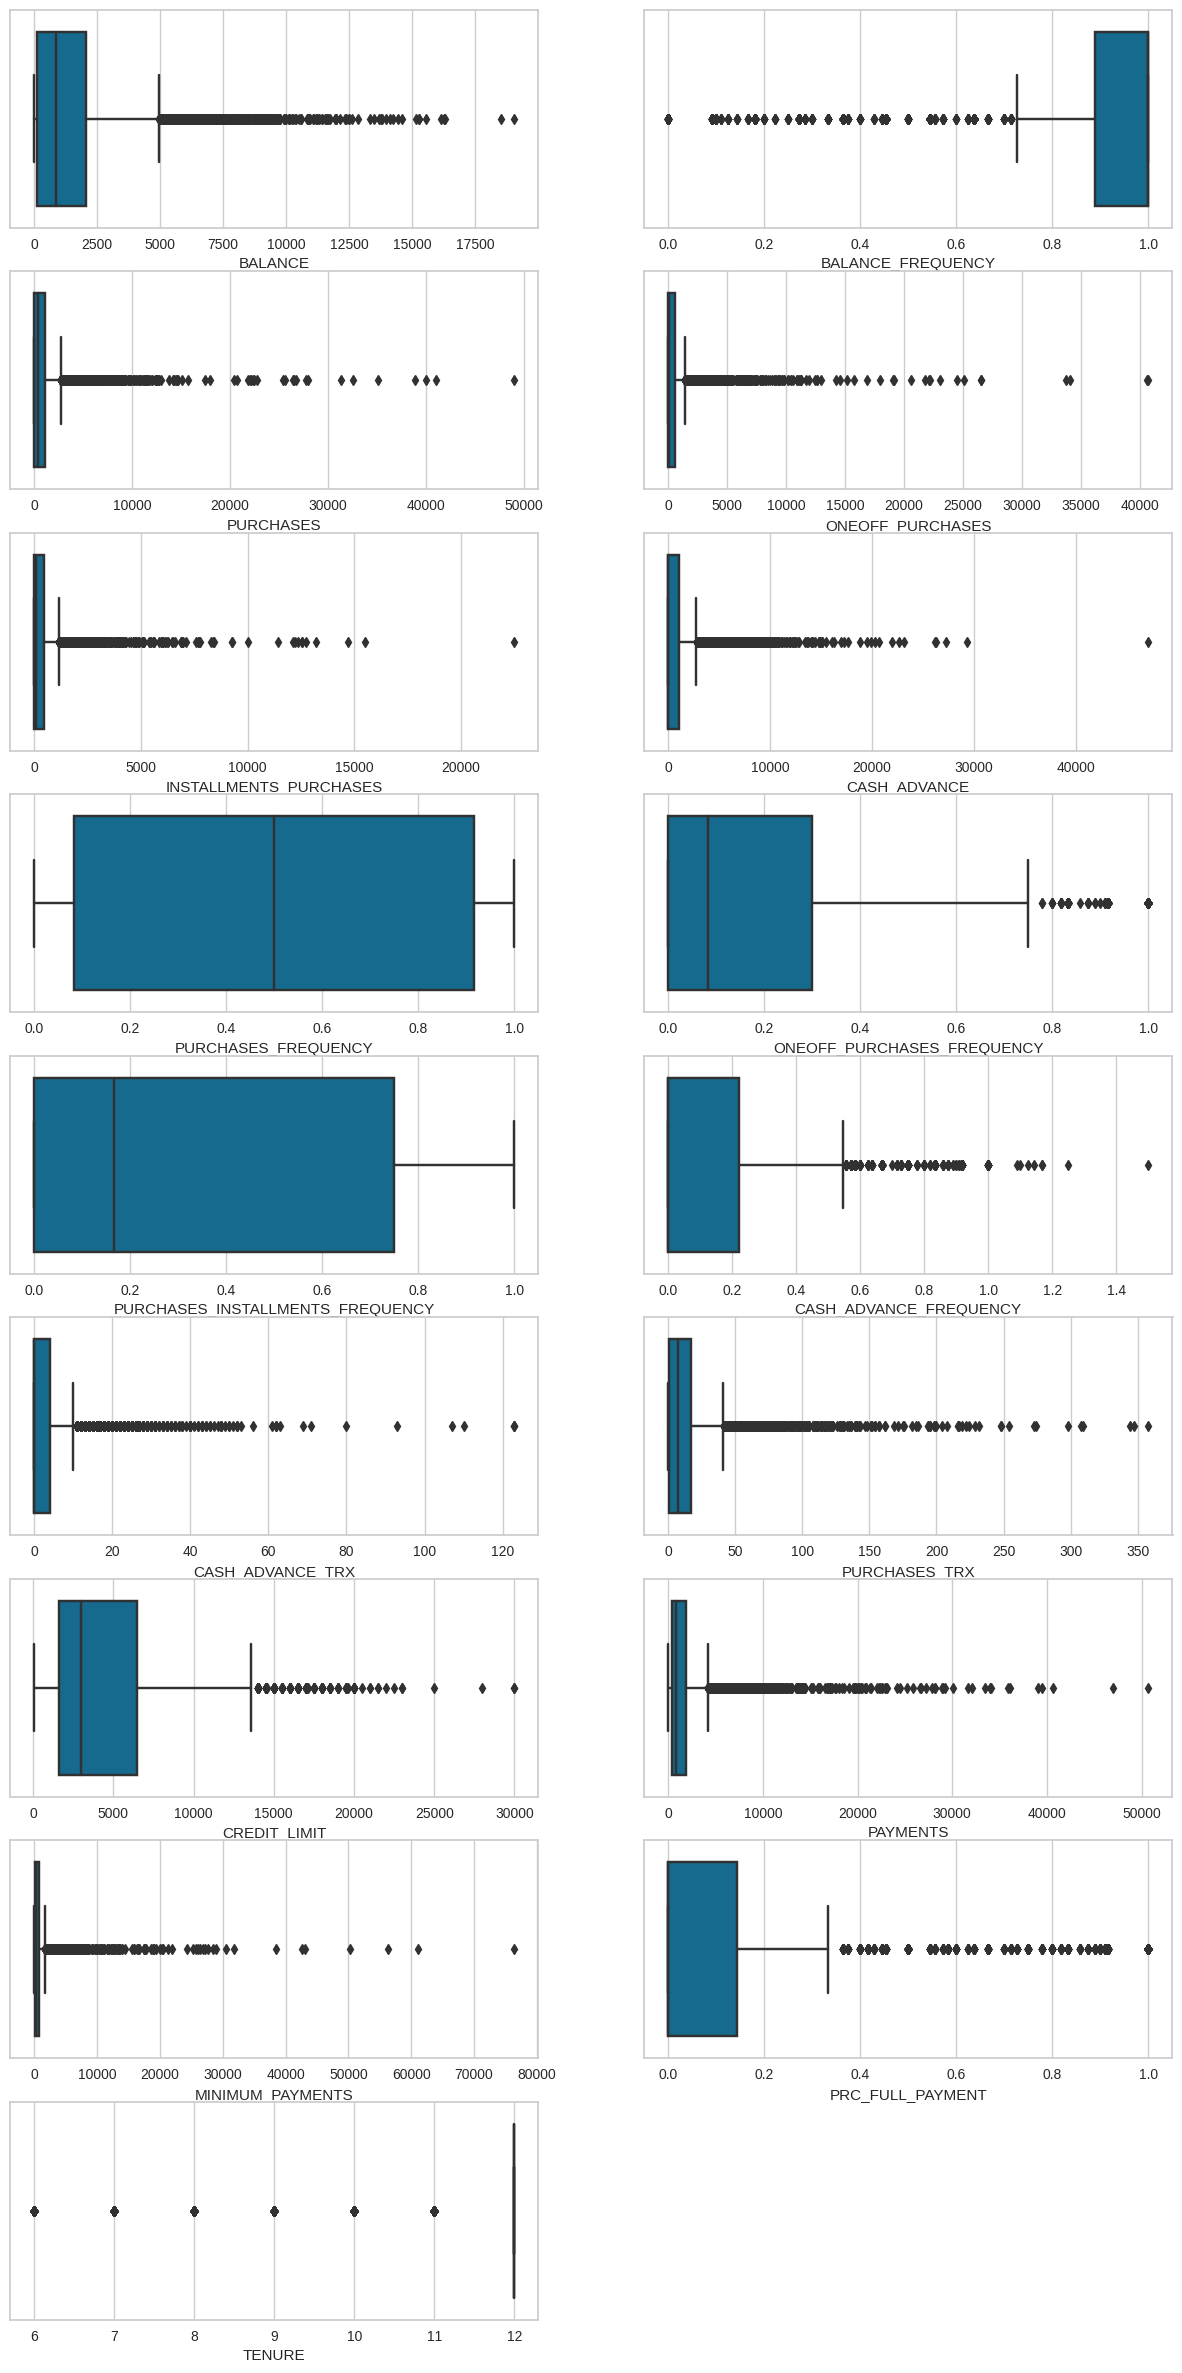

In [ ]:
# --- Analisis de outliers ---
plt.figure(figsize=(15,30))
for i, col in enumerate(dataset.columns):
    if dataset[col].dtype != 'object':
        ax = plt.subplot(9, 2, i)
        sns.boxplot(x = dataset[col], ax=ax)
        plt.xlabel(col)
plt.show()

**E2: Identificar los valores extremos para cada variable (rango)**

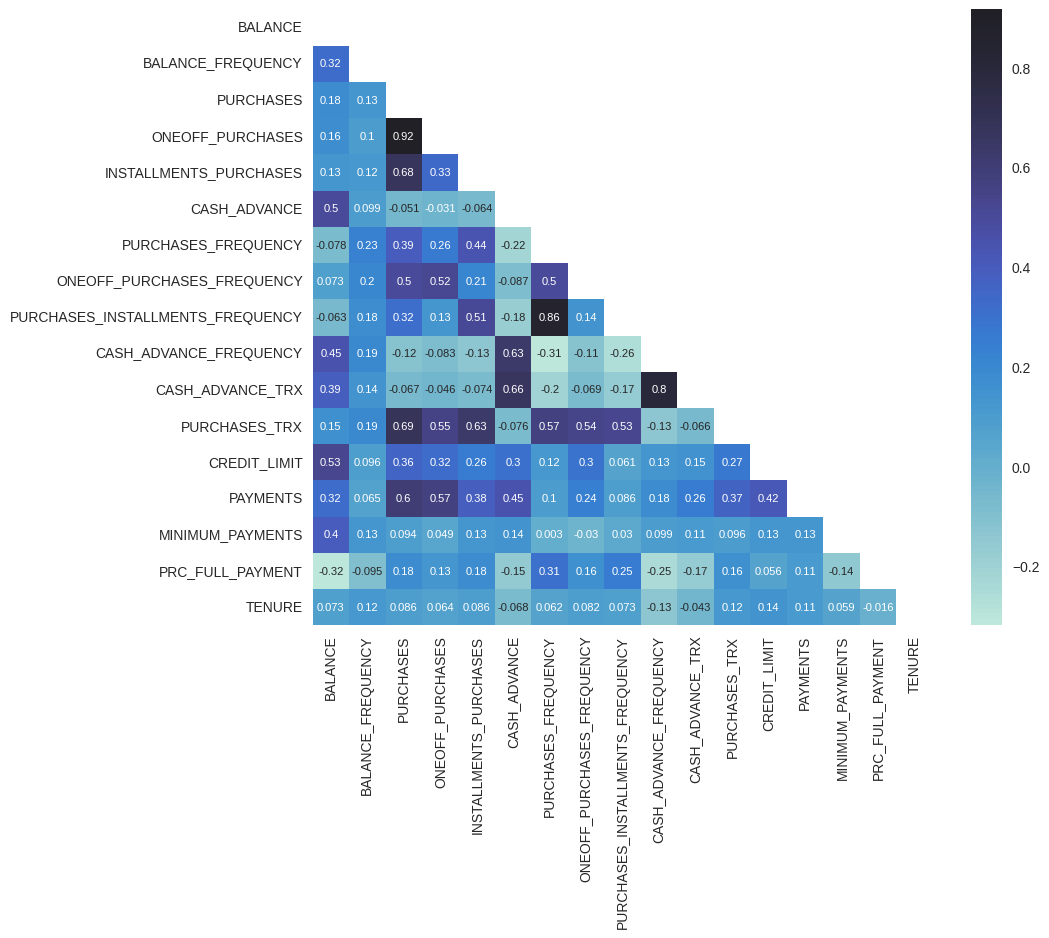

In [ ]:
# --- Correlation Map (Heatmap) ---
mask = np.triu(np.ones_like(dataset.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.corr(), center = 1, mask = mask, cbar = True, annot = True, ax = ax, annot_kws={"size":8})
plt.show()

## Preprocesamiento de los datos

In [148]:
# --- Copia del dataset original ---
df = dataset.copy()
print("Tamaño del dataset sin tratamiento: ", df.shape)

Tamaño del dataset sin tratamiento:  (8950, 18)


### Tratamiento de valores ausentes

In [149]:
# --- Identificación de nulls
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [150]:
# Eliminación de valores null en columna credit_limit
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)

# Imputación por mediana de valores null en columna minimum_payment
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

print("Tamaño del dataset con tratamiento de valores null: ", df.shape)

Tamaño del dataset con tratamiento de valores null:  (8949, 18)


In [151]:
df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Eliminación de variables irrelevantes


In [152]:
# --- Eliminación de columna CUST_ID ---
df = df.drop(['CUST_ID'], axis=1)

In [153]:
# --- Identificación de variables con baja varianza ---
normalized_data = normalize(df)
norm_data = pd.DataFrame(normalized_data, columns = df.columns)
norm_data.var()

BALANCE                             4.791012e-02
BALANCE_FREQUENCY                   4.672481e-08
PURCHASES                           2.720668e-02
ONEOFF_PURCHASES                    1.567946e-02
INSTALLMENTS_PURCHASES              1.207090e-02
CASH_ADVANCE                        4.125506e-02
PURCHASES_FREQUENCY                 2.893577e-08
ONEOFF_PURCHASES_FREQUENCY          4.561785e-09
PURCHASES_INSTALLMENTS_FREQUENCY    2.587127e-08
CASH_ADVANCE_FREQUENCY              3.242316e-09
CASH_ADVANCE_TRX                    1.579599e-06
PURCHASES_TRX                       1.338406e-05
CREDIT_LIMIT                        4.086971e-02
PAYMENTS                            3.938691e-02
MINIMUM_PAYMENTS                    2.379258e-02
PRC_FULL_PAYMENT                    1.285756e-08
TENURE                              7.666298e-06
dtype: float64

In [154]:
## --- Eliminación de variables con baja varianza ---
df = df.drop(['ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY'], axis = 1)

print("Tamaño del dataset con eliminación de variables irrelevantes: ", df.shape)

Tamaño del dataset con eliminación de variables irrelevantes:  (8949, 15)


### Tratamiento de ruido / valores extremos

In [155]:
# --- Identificación de valores extremos o ruido ---
media = df.mean()
std = df.std()
limite_superior = media + 5 * std
limite_inferior = media - 5 * std
outliers = df[(df > limite_superior) | (df < limite_inferior)].stack()
print("Cantidad de valores extremos: ",len(outliers))

Cantidad de valores extremos:  455


In [156]:
# --- Muestra de valores extremos ---
outliers[:10]

20   MINIMUM_PAYMENTS          13557.29726
30   BALANCE                   12136.21996
34   MINIMUM_PAYMENTS          17862.55831
39   PAYMENTS                  20071.07544
71   CASH_ADVANCE              27296.48576
     PAYMENTS                  28232.69446
107  CASH_ADVANCE_TRX             40.00000
122  INSTALLMENTS_PURCHASES     5580.85000
124  BALANCE                   14224.11541
125  PURCHASES                 12462.44000
dtype: float64

In [157]:
# --- los 10 valores mas grandes de columna BALANCE ---
df['BALANCE'].nlargest(10)

138     19043.13856
4140    18495.55855
5488    16304.88925
6629    16259.44857
5281    16115.59640
2361    15532.33972
520     15258.22590
585     15244.74865
4708    15155.53286
883     14581.45914
Name: BALANCE, dtype: float64

In [158]:
# --- Eliminación de valores extremos ---
df_1 = df.copy()
df_1 = df_1.drop(outliers.index.get_level_values(0))

print("Tamaño del dataset con eliminación de valores extremos: ", df_1.shape)

Tamaño del dataset con eliminación de valores extremos:  (8649, 15)


### Escalado de variables

In [159]:
# --- Estandarización de variables ---
scaler = StandardScaler()
X = scaler.fit_transform(df_1)

## Algoritmos de Clustering

### K-MEANS

In [160]:
# --- Determinar el número de clusters - Método 1 ---

#Definición de argumentos
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# Lista que almacena los valores de SSE para cada valor K
sse = []

for k in range(2, 20):
  model_k = KMeans(n_clusters = k, **kmeans_constants)
  model_k.fit(X)
  sse.append(model_k.inertia_)

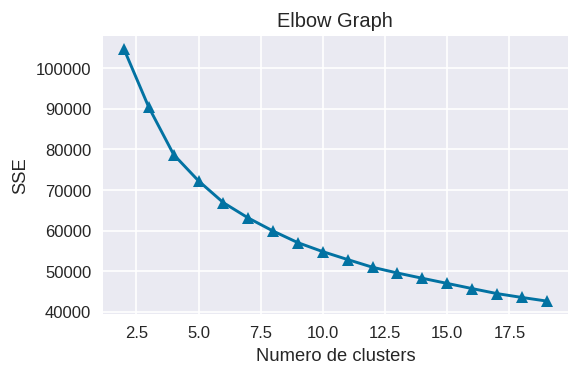

In [164]:
# --- Gráfica de valores se inercia ---
plt.figure(figsize = (5, 3), dpi = 120)
plt.plot(range(2, 20), sse, color = 'b', marker = '^')
plt.xlabel('Numero de clusters')
plt.ylabel('SSE')
plt.title('Elbow Graph')
plt.show()

In [162]:
# --- Selección automática de k ---
kl = KneeLocator(range(2, 20), sse, curve = 'convex', direction = 'decreasing')
kl.elbow

7

In [163]:
# --- Determinar el número de clusters - Método 2 ---

# Lista que almacena los valores de score de silueta para cada valor K
silhoutte_coefs = []

for k in range(2, 20):
  model_k = KMeans(n_clusters = k, **kmeans_constants)
  model_k.fit(X)
  silhoutte_coefs.append(silhouette_score(X, model_k.labels_))

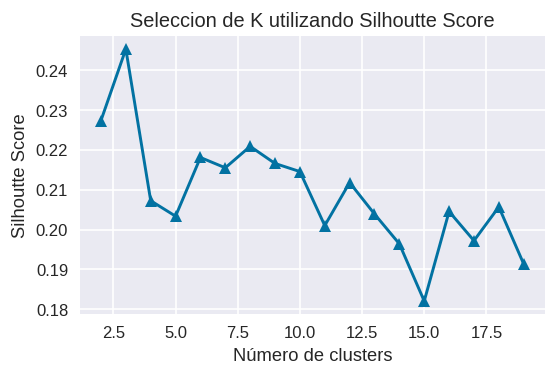

In [165]:
# --- Gráfica de valores se silueta ---
plt.figure(figsize = (5, 3), dpi = 120)
plt.plot(range(2, 20), silhoutte_coefs, color = 'b', marker = '^')
plt.xlabel('Número de clusters')
plt.ylabel('Silhoutte Score')
plt.title('Seleccion de K utilizando Silhoutte Score')
plt.show()

In [166]:
# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(X)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

In [167]:
# --- Análicemos los resultados ---
centroids = scaler.inverse_transform(model_kmeans.cluster_centers_)
centroids = pd.DataFrame(centroids, columns = df_1.columns)

plt.style.use('default')
i = 1
while i < len(df_1.columns):
    try:
        fig = plt.figure(figsize = (10, 15))
        plt.subplot(1,2,1)
        plt.scatter(centroids['BALANCE'], centroids[df_1.columns[i]], marker = '*', c = 'r')
        plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                    c = model_kmeans.labels_.astype(float), alpha = 0.8)
        plt.xlabel('BALANCE')
        plt.ylabel(df_1.columns[i])
        plt.grid()
        i += 1
        plt.subplot(1,2,2)
        plt.scatter(centroids['BALANCE'], centroids[df_1.columns[i]], marker = '*', c = 'r')
        plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                    c = model_kmeans.labels_.astype(float), alpha = 0.8)
        plt.xlabel('BALANCE')
        plt.ylabel(df_1.columns[i])
        plt.grid()
        i += 1
    except IndexError:
        break
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [168]:
# --- Evaluación del modelo ---
print('Inertia : ', model_kmeans.inertia_)
print('Silhouette Score : ', silhouette_score(X, model_kmeans.labels_))

Inertia :  90374.40453413595
Silhouette Score :  0.24529816000675297


### DBSCAN

In [171]:
# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X)

distances, *other = neighbors.kneighbors(X)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(8649,)


array([6.15736253e-03, 6.15736253e-03, 7.76312670e-03, ...,
       5.42696295e+00, 5.55380682e+00, 6.42981152e+00])

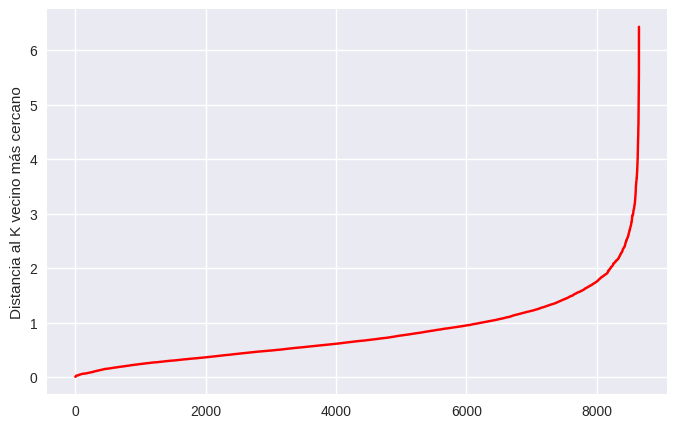

In [172]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [173]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

8607

In [174]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

3.5891075987330012

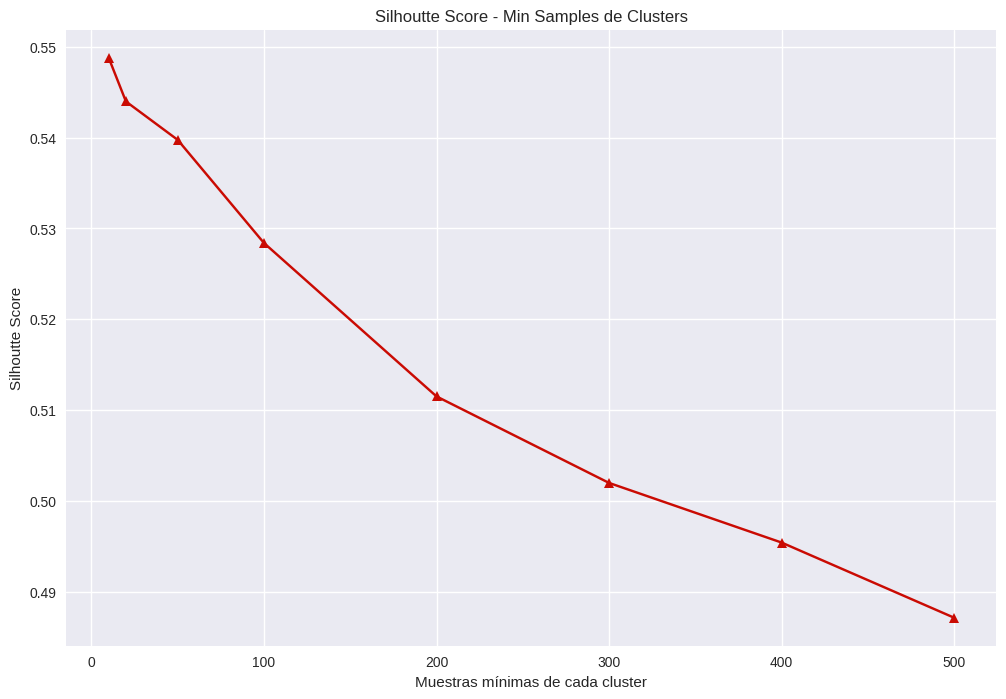

In [175]:
# --- Selección de hiperparámetros min_sample ---

silhoutte_coefs = []

for min_points in [10, 20, 50, 100, 200, 300, 400, 500]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X)
    silhoutte_coefs.append(silhouette_score(X, model_d.labels_))
    
plt.figure(figsize = (12, 8))
plt.plot([10, 20, 50, 100, 200, 300, 400, 500], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [176]:
# --- Modelo DBSCAN ---
model_db = DBSCAN(eps = epsilon, min_samples = 10)
model_db.fit(X)

DBSCAN(eps=3.5891075987330012, min_samples=10)

In [177]:
plt.style.use('default')
i = 1
while i < len(df_1.columns):
    try:
      fig = plt.figure(figsize = (10, 15))
      plt.subplot(1,2,1)
      plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                  c = model_db.labels_.astype(float), alpha = 0.8)
      plt.xlabel('BALANCE')
      plt.ylabel(df_1.columns[i])
      plt.grid()
      i += 1
      plt.subplot(1,2,2)
      plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                  c = model_db.labels_.astype(float), alpha = 0.8)
      plt.xlabel('BALANCE')
      plt.ylabel(df_1.columns[i])
      plt.grid()
      i += 1
    except IndexError:
      break
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [178]:
# --- Evaluación del modelo ---
print('Silhouette Score : ', silhouette_score(X, model_db.labels_))

Silhouette Score :  0.5487955794946413


### Gaussian Mixture Model

Text(0.5, 0, 'Número de Clusters')

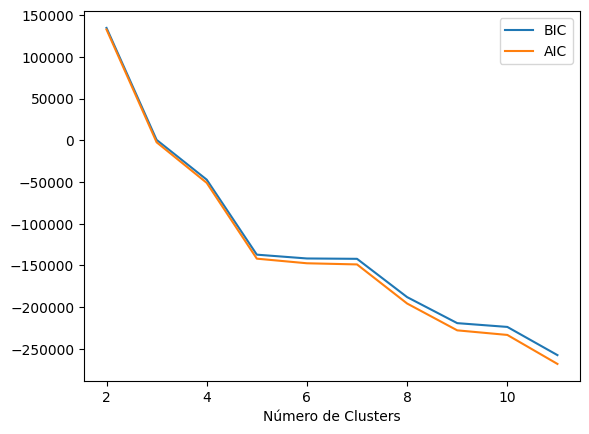

In [179]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 12)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(X) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [180]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=5, random_state=123, covariance_type = 'full').fit(X)

In [181]:
labels = model_gmm.predict(X)

plt.style.use('default')
i = 1
while i < len(df_1.columns):
    try:
      fig = plt.figure(figsize = (10, 15))
      plt.subplot(1,2,1)
      plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                  c = labels.astype(float), alpha = 0.8)
      plt.xlabel('BALANCE')
      plt.ylabel(df_1.columns[i])
      plt.grid()
      i += 1
      plt.subplot(1,2,2)
      plt.scatter(df_1['BALANCE'], df_1[df_1.columns[i]],
                  c = labels.astype(float), alpha = 0.8)
      plt.xlabel('BALANCE')
      plt.ylabel(df_1.columns[i])
      plt.grid()
      i += 1
    except IndexError:
      break
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [182]:
# --- Evaluación del modelo ---
print('Silhouette Score : ', silhouette_score(X, labels))

Silhouette Score :  0.05304651863577037


### Evaluación de los algoritmos

**Calinski Harabasz Score:** 

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster). 

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.


In [183]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X, model_kmeans.labels_))

# --- Evaluación del modelo DBscan ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X, model_db.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X, model_db.labels_))

# --- Evaluación del modelo Gaussian Mixture Model ---
print(" ### GAUSSIAN MIXTURE MODEL ###")
print('Silhouette Score : ', silhouette_score(X, labels))
print('Calinski harabasz score: ', calinski_harabasz_score(X, labels))

 ### K-MEANS ###
Inertia:  90374.40453413595
Silhouette Score:  0.24529816000675297
Calinski harabasz score:  1882.7886099459838
 ### DBSCAN ###
Silhouette Score:  0.5487955794946413
Calinski harabasz score:  312.22746542260893
 ### GAUSSIAN MIXTURE MODEL ###
Silhouette Score :  0.05304651863577037
Calinski harabasz score:  575.5438977767855


## Aplicación de algoritmos de clustering y PCA para la reducción de dimensiones

### PCA

In [184]:
# --- Aplicación de PCA para reducción de la dimensionalidad ---
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)

In [185]:
X_pca

array([[-1.70958703, -1.21100408,  0.04320117],
       [-1.42188198,  3.10165135,  0.88792849],
       [ 0.19122737,  0.13908732, -0.14131506],
       ...,
       [-0.72624169, -2.11158802, -0.64567425],
       [-2.40351441, -1.42168142,  0.57434255],
       [-0.71284853, -1.28818379,  0.87734933]])

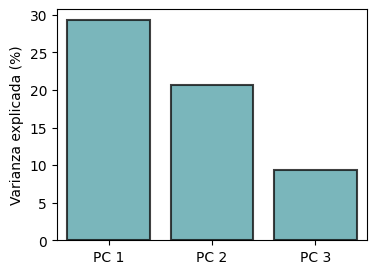

In [186]:
# --- Varianza explicada ---
PCA_variance = pd.DataFrame({'Varianza explicada (%)': 
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (4, 3))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 4)], 
                  y = PCA_variance['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8', 
                  alpha = 0.8)

plt.show()

In [187]:
PCA_variance

,Varianza explicada (%)
0,29.271173
1,20.709336
2,9.300811


Las loadings o cargas  pueden interpretarse como el peso/importancia que tiene cada variable en cada componente y, por lo tanto, ayudan a conocer que tipo de información recoge cada una de las componentes.

In [52]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = df_1.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

,PC 1,PC 2,PC 3
BALANCE,0.04,0.48,-0.16
BALANCE_FREQUENCY,0.13,0.18,-0.40
PURCHASES,0.43,0.05,0.25
ONEOFF_PURCHASES,0.33,0.09,0.43
INSTALLMENTS_PURCHASES,0.37,-0.03,-0.16
CASH_ADVANCE,-0.08,0.44,0.03
PURCHASES_FREQUENCY,0.38,-0.15,-0.27
PURCHASES_INSTALLMENTS_FREQUENCY,0.34,-0.16,-0.40
CASH_ADVANCE_TRX,-0.09,0.40,-0.05
PURCHASES_TRX,0.42,0.00,-0.02


### K-means con PCA

In [188]:
# --- Determinar el número de clusters - Método 1 ---

#Definición de argumentos
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# Lista que almacena los valores de SSE para cada valor K
sse = []

for k in range(2, 10):
  model_k = KMeans(n_clusters = k, **kmeans_constants)
  model_k.fit(X_pca)
  sse.append(model_k.inertia_)

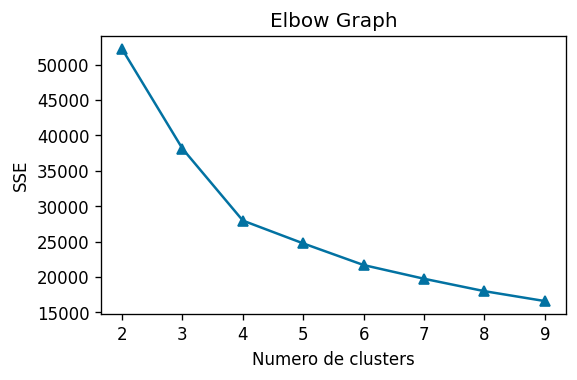

In [189]:
# --- Gráfica de valores se inercia ---
plt.figure(figsize = (5, 3), dpi = 120)
plt.plot(range(2, 10), sse, color = 'b', marker = '^')
plt.xlabel('Numero de clusters')
plt.ylabel('SSE')
plt.title('Elbow Graph')
plt.show()

In [190]:
# --- Selección automática de k ---
kl = KneeLocator(range(2, 10), sse, curve = 'convex', direction = 'decreasing')
kl.elbow

4

In [191]:
# --- Determinar el número de clusters - Método 2 ---

# Lista que almacena los valores de score de silueta para cada valor K
silhoutte_coefs = []

for k in range(2, 10):
  model_k = KMeans(n_clusters = k, **kmeans_constants)
  model_k.fit(X_pca)
  silhoutte_coefs.append(silhouette_score(X_pca, model_k.labels_))

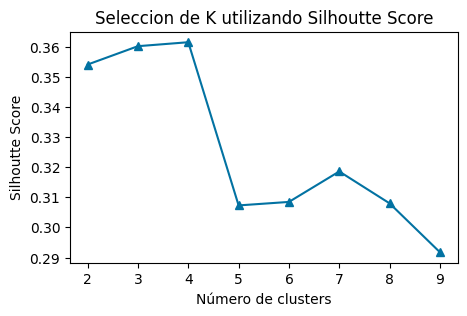

In [192]:
# --- Gráfica de valores se silueta ---
plt.figure(figsize = (5, 3))
plt.plot(range(2, 10), silhoutte_coefs, color = 'b', marker = '^')
plt.xlabel('Número de clusters')
plt.ylabel('Silhoutte Score')
plt.title('Seleccion de K utilizando Silhoutte Score')
plt.show()

In [193]:
# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
y_kmeans = model_kmeans.fit_predict(X_pca)

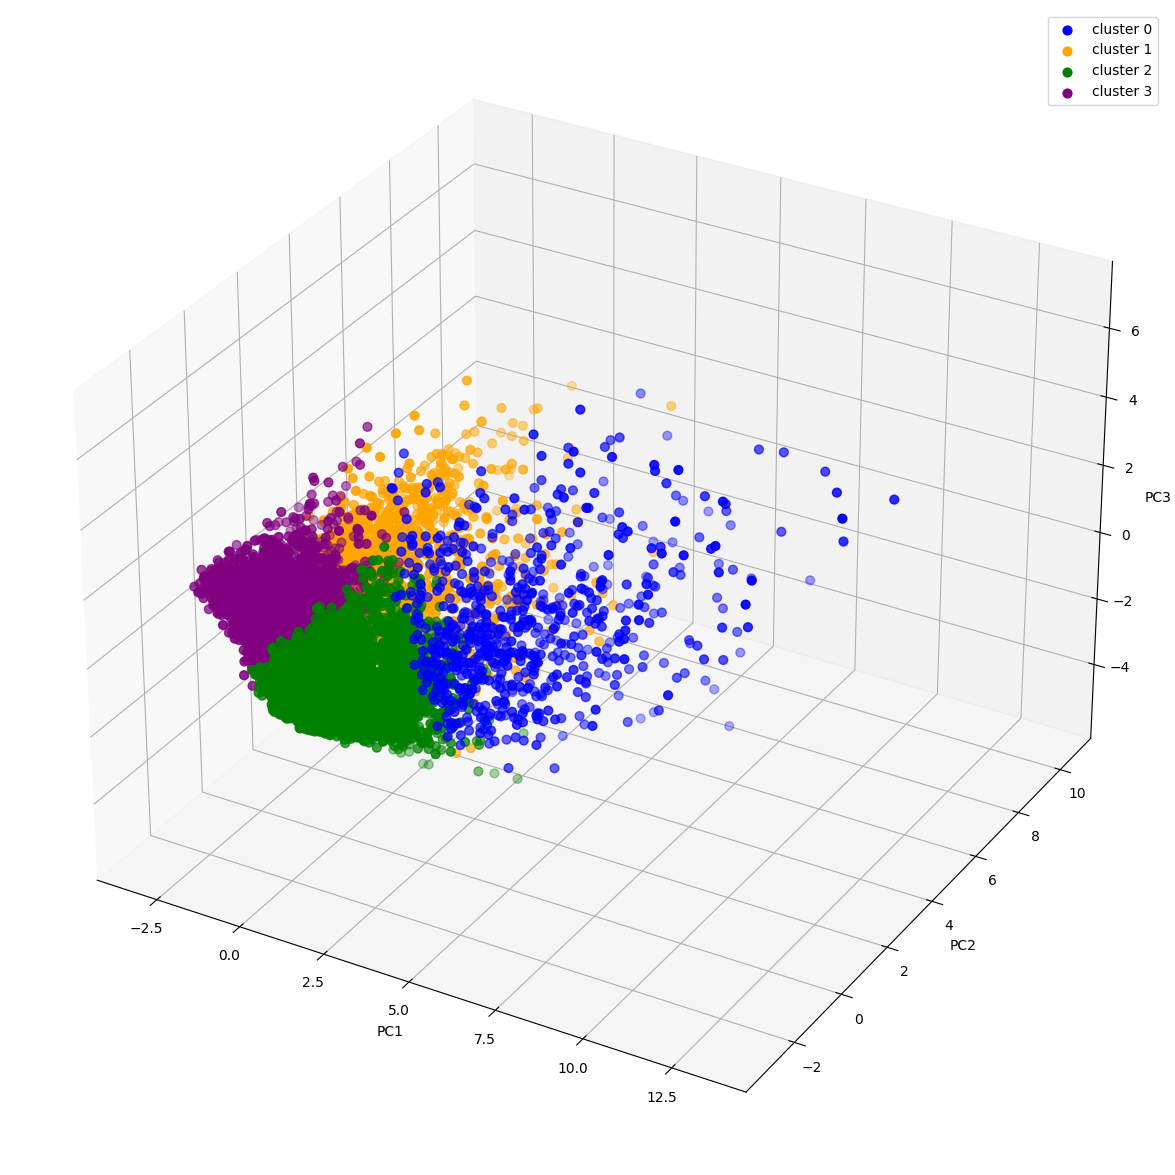

In [196]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y_kmeans == 0,0],X_pca[y_kmeans == 0,1],X_pca[y_kmeans == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[y_kmeans == 1,0],X_pca[y_kmeans == 1,1],X_pca[y_kmeans == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[y_kmeans == 2,0],X_pca[y_kmeans == 2,1],X_pca[y_kmeans == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[y_kmeans == 3,0],X_pca[y_kmeans == 3,1],X_pca[y_kmeans == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [197]:
# --- Evaluación del modelo ---
print('Inertia : ', model_kmeans.inertia_)
print('Silhouette Score : ', silhouette_score(X_pca, model_kmeans.labels_))

Inertia :  27954.75422041215
Silhouette Score :  0.36142011564752713


### DBSCAN con PCA

In [198]:
# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X_pca)

distances, *other = neighbors.kneighbors(X_pca)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(8649,)


array([2.39334579e-03, 2.39334579e-03, 2.91335729e-03, ...,
       1.83320117e+00, 2.38794361e+00, 2.84383611e+00])

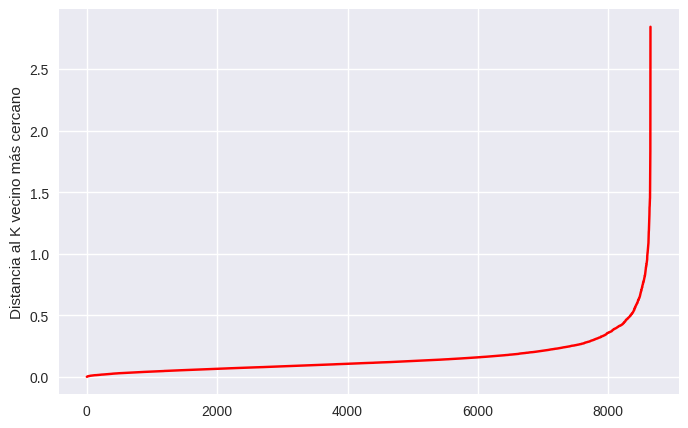

In [199]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [200]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

8634

In [201]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

1.3759248967238187

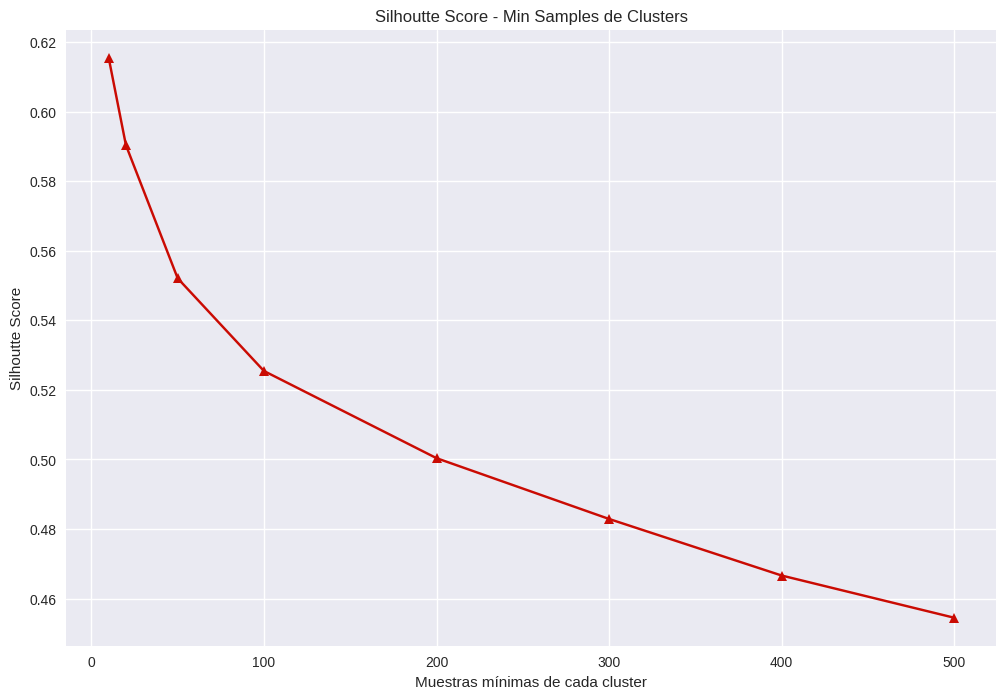

In [202]:
# --- Selección de hiperparámetros min_sample ---

silhoutte_coefs = []

for min_points in [10, 20, 50, 100, 200, 300, 400, 500]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X_pca)
    silhoutte_coefs.append(silhouette_score(X_pca, model_d.labels_))
    
plt.figure(figsize = (12, 8))
plt.plot([10, 20, 50, 100, 200, 300, 400, 500], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [203]:
# --- Modelo DBSCAN ---
model_db = DBSCAN(eps = epsilon, min_samples = 10)
y_dbscan = model_db.fit_predict(X_pca)

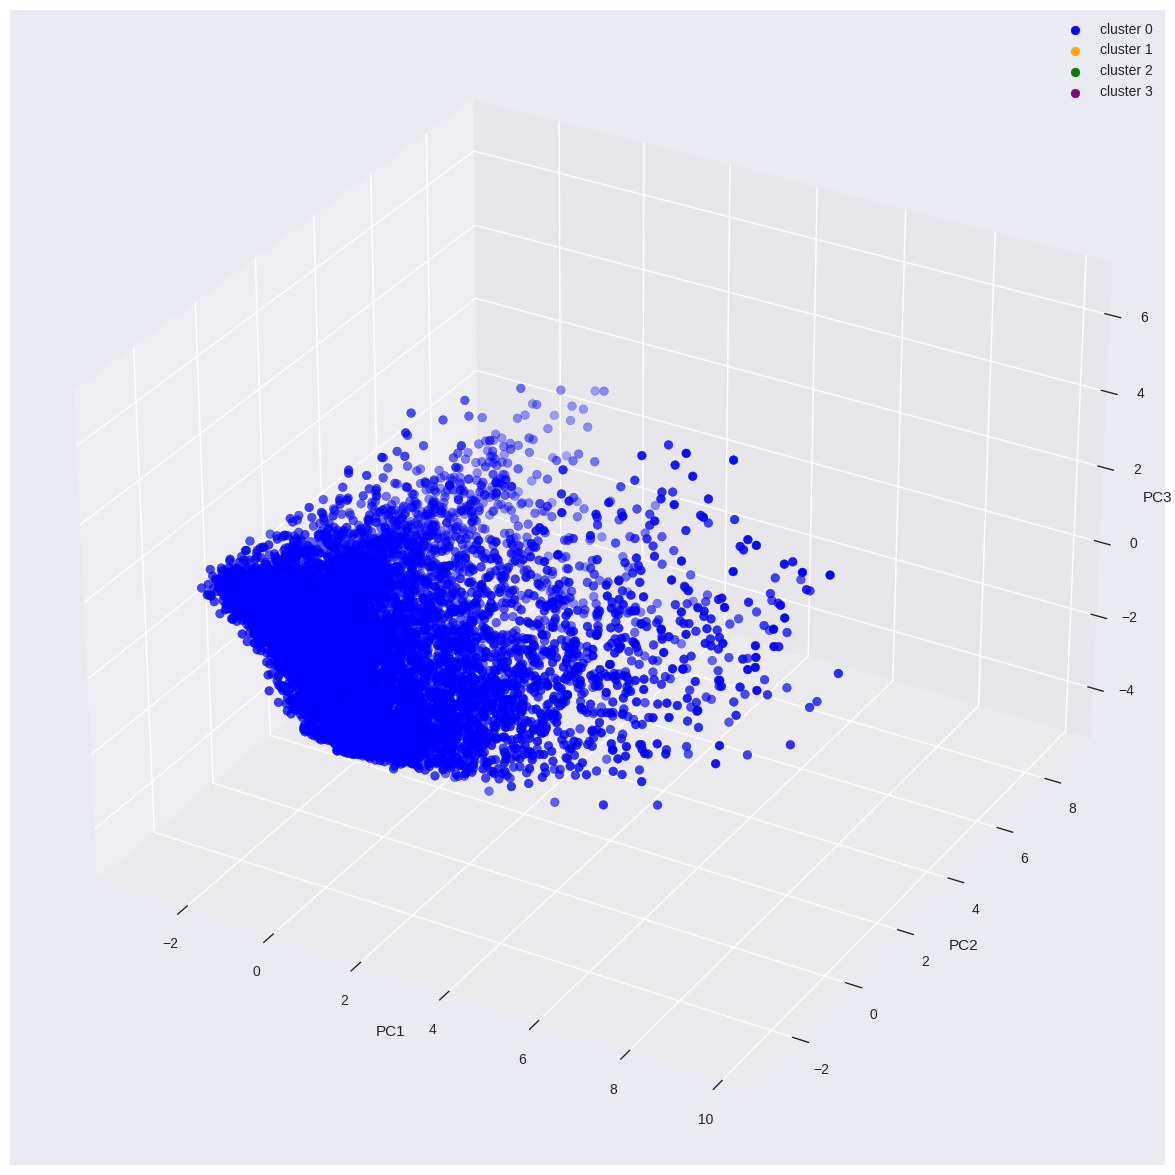

In [205]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y_dbscan == 0,0],X_pca[y_dbscan == 0,1],X_pca[y_dbscan == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[y_dbscan == 1,0],X_pca[y_dbscan == 1,1],X_pca[y_dbscan == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[y_dbscan == 2,0],X_pca[y_dbscan == 2,1],X_pca[y_dbscan == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[y_dbscan == 3,0],X_pca[y_dbscan == 3,1],X_pca[y_dbscan == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [206]:
# --- Evaluación del modelo ---
print('Silhouette Score : ', silhouette_score(X_pca, model_db.labels_))

Silhouette Score :  0.6154945666215208


### Gaussian Mixture Model con PCA


Text(0.5, 0, 'Número de Clusters')

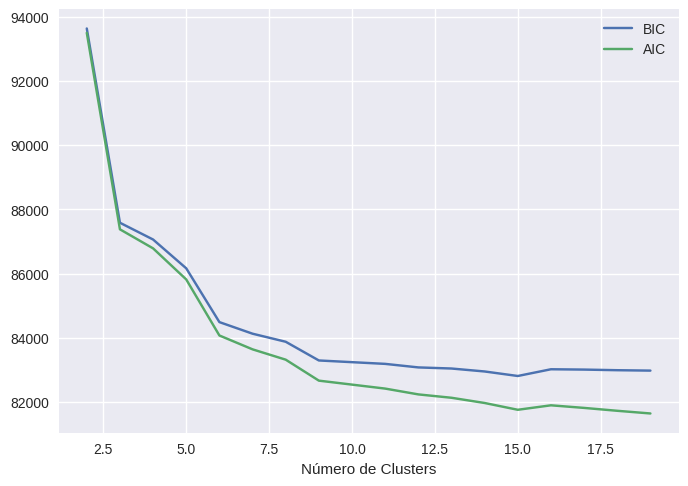

In [207]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 20)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X_pca) for n in n_components]

plt.plot(n_components, [m.bic(X_pca) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(X_pca) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [208]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=5, random_state=123, covariance_type = 'full')
y_gmm = model_gmm.fit_predict(X_pca)

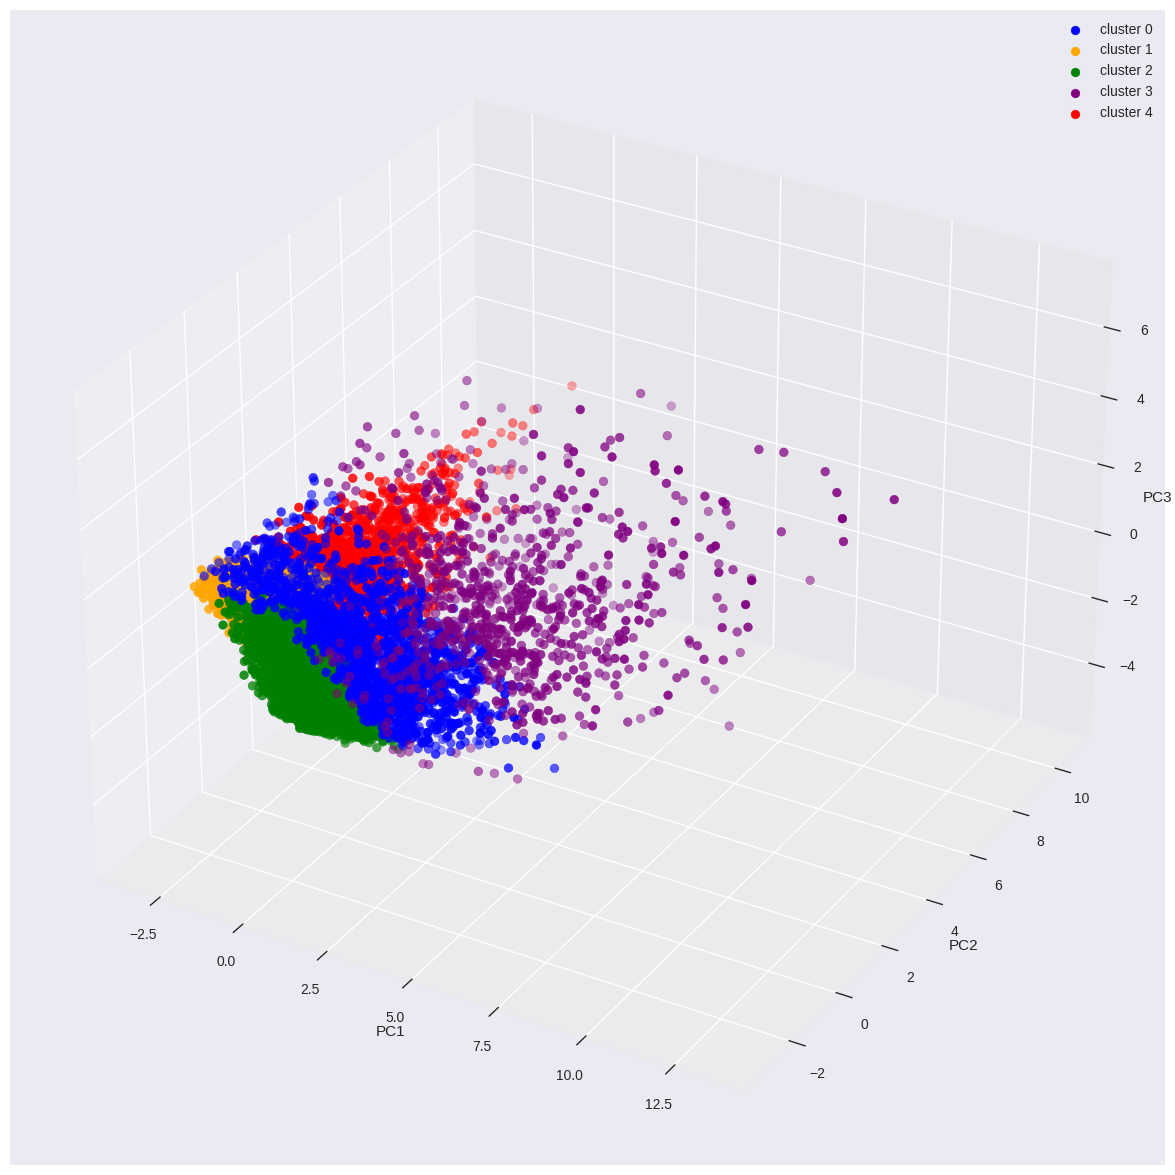

In [209]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y_gmm == 0,0],X_pca[y_gmm == 0,1],X_pca[y_gmm == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[y_gmm == 1,0],X_pca[y_gmm == 1,1],X_pca[y_gmm == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[y_gmm == 2,0],X_pca[y_gmm == 2,1],X_pca[y_gmm == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[y_gmm == 3,0],X_pca[y_gmm == 3,1],X_pca[y_gmm == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X_pca[y_gmm == 4,0],X_pca[y_gmm == 4,1],X_pca[y_gmm == 4,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [210]:
# --- Evaluación del modelo ---
print('Silhouette Score : ', silhouette_score(X_pca, y_gmm))

Silhouette Score :  0.2117398596889939


### Evaluación de los modelos con PCA

In [211]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, y_kmeans))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, y_kmeans))

# --- Evaluación del modelo DBscan ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, y_dbscan))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, y_dbscan))

# --- Evaluación del modelo Gaussian Mixture Model ---
print(" ### GAUSSIAN MIXTURE MODEL ###")
print('Silhouette Score : ', silhouette_score(X_pca, y_gmm))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, y_gmm))

 ### K-MEANS ###
Inertia:  27954.75422041215
Silhouette Score:  0.36142011564752713
Calinski harabasz score:  5046.327594678081
 ### DBSCAN ###
Silhouette Score:  0.6154945666215208
Calinski harabasz score:  586.1313556947721
 ### GAUSSIAN MIXTURE MODEL ###
Silhouette Score :  0.2117398596889939
Calinski harabasz score:  2641.813334225797


## Interpretación de Clusters para modelo de K-means

In [214]:
# --- Agregar agrupación K-Means al conjunto df1 ----
df_1['cluster_result'] = y_kmeans+1
df_1['cluster_result'] = 'Cluster '+ df_1['cluster_result'].astype(str)

# --- Calcular Meadia de las variables de DF1 ---
df_profile_overall = pd.DataFrame()
df_profile_overall['Overall'] = df_1.describe().loc[['mean']].T

# --- Summarizar media de cada cluster--- 
df_cluster_summary = df_1.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0': 'Atributo', 'level_1': 'Métrica'})
df_cluster_summary = df_cluster_summary[df_cluster_summary['Métrica'] == 'mean'].set_index('Atributo')

# --- Combining Both Data Frame ---
df_profile = df_cluster_summary.join(df_profile_overall).reset_index()
df_profile.round(2)

,Atributo,Métrica,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Overall
0,BALANCE,mean,2272.98,4387.68,761.87,875.31,1445.77
1,BALANCE_FREQUENCY,mean,0.98,0.97,0.93,0.78,0.87
2,PURCHASES,mean,4186.71,399.55,979.36,254.61,840.05
3,ONEOFF_PURCHASES,mean,2773.75,268.65,393.32,206.05,488.41
4,INSTALLMENTS_PURCHASES,mean,1413.03,130.98,586.53,48.69,351.87
5,CASH_ADVANCE,mean,597.80,3574.31,177.85,564.55,861.05
6,PURCHASES_FREQUENCY,mean,0.94,0.26,0.87,0.18,0.49
7,PURCHASES_INSTALLMENTS_FREQUENCY,mean,0.74,0.15,0.73,0.08,0.36
8,CASH_ADVANCE_TRX,mean,1.89,10.54,0.77,2.22,2.88
9,PURCHASES_TRX,mean,54.72,5.83,19.33,3.00,13.10
